# **Waste Classification Project - Dataset Preprocessing Pipeline**

🗂 Table of Contents:

Step 1 | Setup and Initialization

Step 2 | Dataset Analysis

Step 3 | Dataset Preparation

3.1 | Centralize Dataset Information

3.2 | Stratified Data Splitting (Train & Validation)

3.3 | Data Augmentation & Rescaling

3.4 | Generating Batches of Images

Step 4 | Addressing Dataset Imbalances

# **step 1: Setup and initoalization**

In [ ]:
import os
import zipfile
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
import tensorflow as tf




In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**NB** : this is the link to the dataset [link](https://drive.google.com/drive/folders/1mn4nIIGB9lKEvSjr3vqjIpHnji48nxnc?usp=drive_link)

so to access the dataset you need to right-click the folder waste_dataset_annotated and choose "Add shortcut to Drive" → place it in "My Drive".

In [ ]:
import os
import zipfile

zip_path = "/content/drive/MyDrive/waste_dataset_annotated.zip"
extract_path = "/content/waste_data_annotated/"

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [ ]:
# # if the data is local
# # Paths
# zip_path = "archive.zip"  # Your local ZIP path
# extract_path = "waste_data"
# # Unzip dataset
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)


# **step 2 : data analysis**

Extracted contents:
waste_dataset_annotated


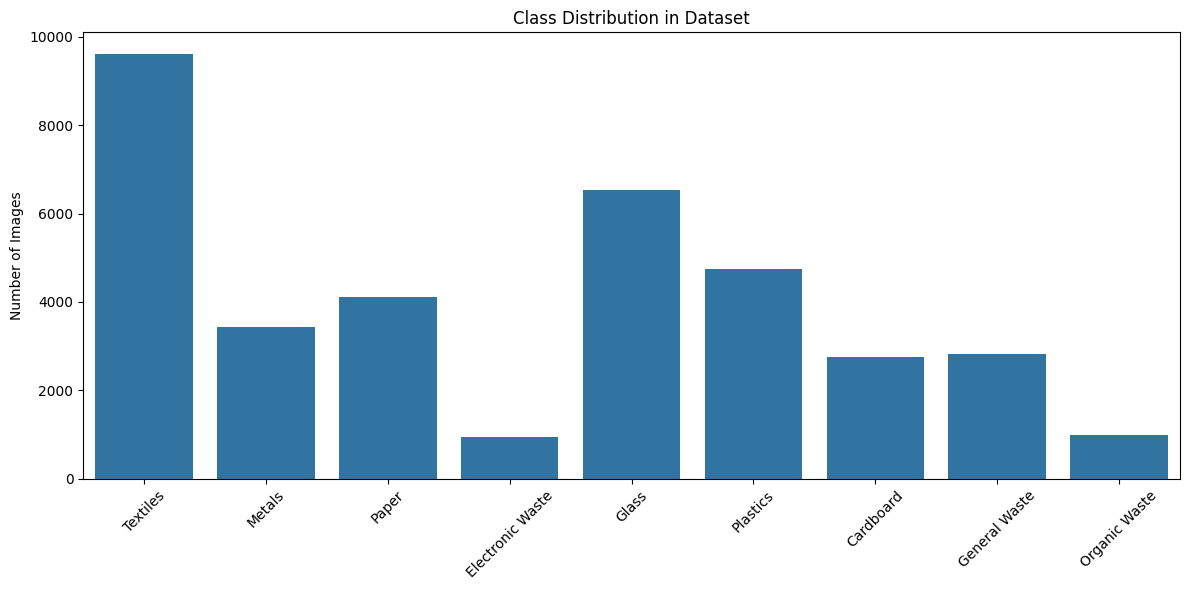

In [ ]:
# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check extracted folder to find the real dataset folder
print("Extracted contents:")
!ls "/content/waste_data_annotated"

# Let’s say the actual data is inside 'waste_dataset_annotated' subfolder:
extract_path = os.path.join(extract_path, "waste_dataset_annotated")

# Step 3: Analyze dataset structure
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_dataset_structure(base_dir):
    class_distribution = {}
    for class_name in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_name)
        if os.path.isdir(class_path):
            num_images = len([
                img for img in os.listdir(class_path)
                if img.lower().endswith(('jpg', 'jpeg', 'png'))
            ])
            class_distribution[class_name] = num_images
    return class_distribution

dataset_stats = analyze_dataset_structure(extract_path)

# Step 4: Visualize
plt.figure(figsize=(12, 6))
sns.barplot(x=list(dataset_stats.keys()), y=list(dataset_stats.values()))
plt.title("Class Distribution in Dataset")
plt.xticks(rotation=45)
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()


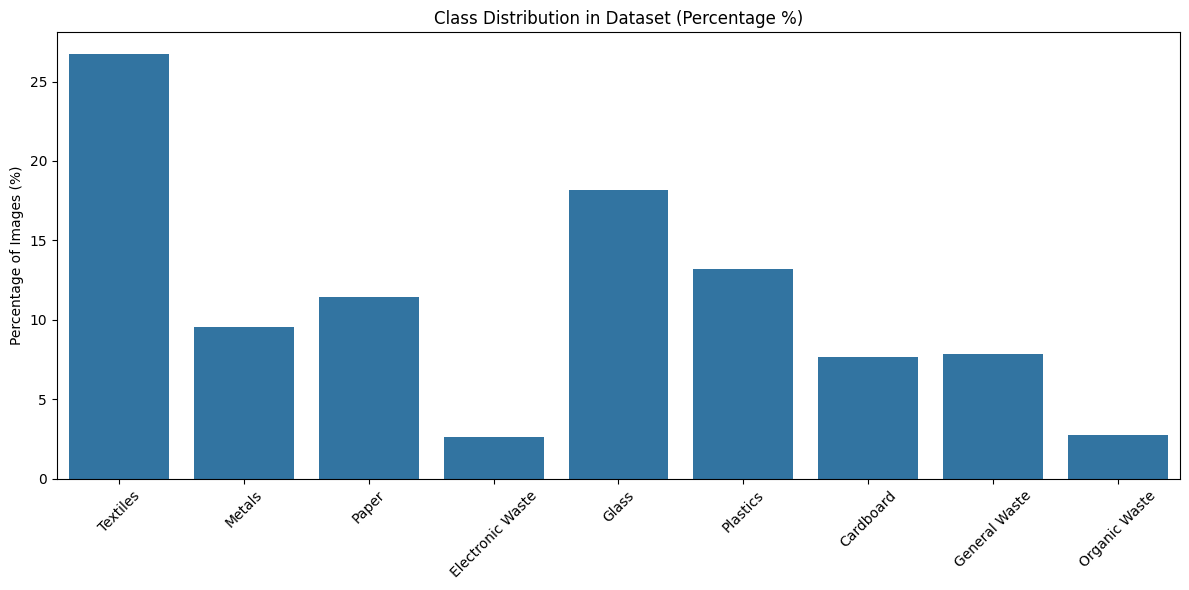

Class Distribution in Percentage:

Textiles: 26.76%
Glass: 18.16%
Plastics: 13.22%
Paper: 11.46%
Metals: 9.54%
General Waste: 7.82%
Cardboard: 7.63%
Organic Waste: 2.77%
Electronic Waste: 2.63%


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

def analyze_dataset_structure(base_dir):
    class_distribution = {}
    for class_name in os.listdir(base_dir):
        # Skip the 'waste_dataset' folder
        if class_name == 'waste_dataset_annotated':
            continue

        class_path = os.path.join(base_dir, class_name)
        if os.path.isdir(class_path):
            num_images = len([
                img for img in os.listdir(class_path)
                if img.lower().endswith(('jpg', 'jpeg', 'png'))
            ])
            class_distribution[class_name] = num_images
    return class_distribution

# Analyze dataset
dataset_stats = analyze_dataset_structure(extract_path)

# Convert to percentages
total_images = sum(dataset_stats.values())
percentage_distribution = {cls: (count / total_images) * 100 for cls, count in dataset_stats.items()}

# Visualize
plt.figure(figsize=(12, 6))
sns.barplot(x=list(percentage_distribution.keys()), y=list(percentage_distribution.values()))
plt.title("Class Distribution in Dataset (Percentage %)")
plt.xticks(rotation=45)
plt.ylabel("Percentage of Images (%)")
plt.tight_layout()
plt.show()
# Print percentage distribution
print("Class Distribution in Percentage:\n")
for cls, percentage in sorted(percentage_distribution.items(), key=lambda x: x[1], reverse=True):
    print(f"{cls}: {percentage:.2f}%")



### **inference from the dataset analysis**


**Imbalanced Dataset:**

The dataset is not balanced, which can affect model training.

For example:

Textiles make up the largest portion with ~27% of the dataset.

Electronic Waste and Organic Waste are severely underrepresented with only ~2-3% each.

**Dominant Classes:**

Textiles 27% and Glass 18% dominate the dataset.

These categories might bias the model to perform better on them, potentially leading to poor generalization on the minority classes.

**Underrepresented Classes:**

Electronic Waste and Organic Waste are the least represented.

A model trained on this dataset may struggle to classify these categories accurately due to insufficient training examples.

**Moderately Represented Classes:**

Classes like Plastics, Paper, and Metals have a more balanced distribution (between ~9%–13%).



Let's visually explore the images from each garbage category:

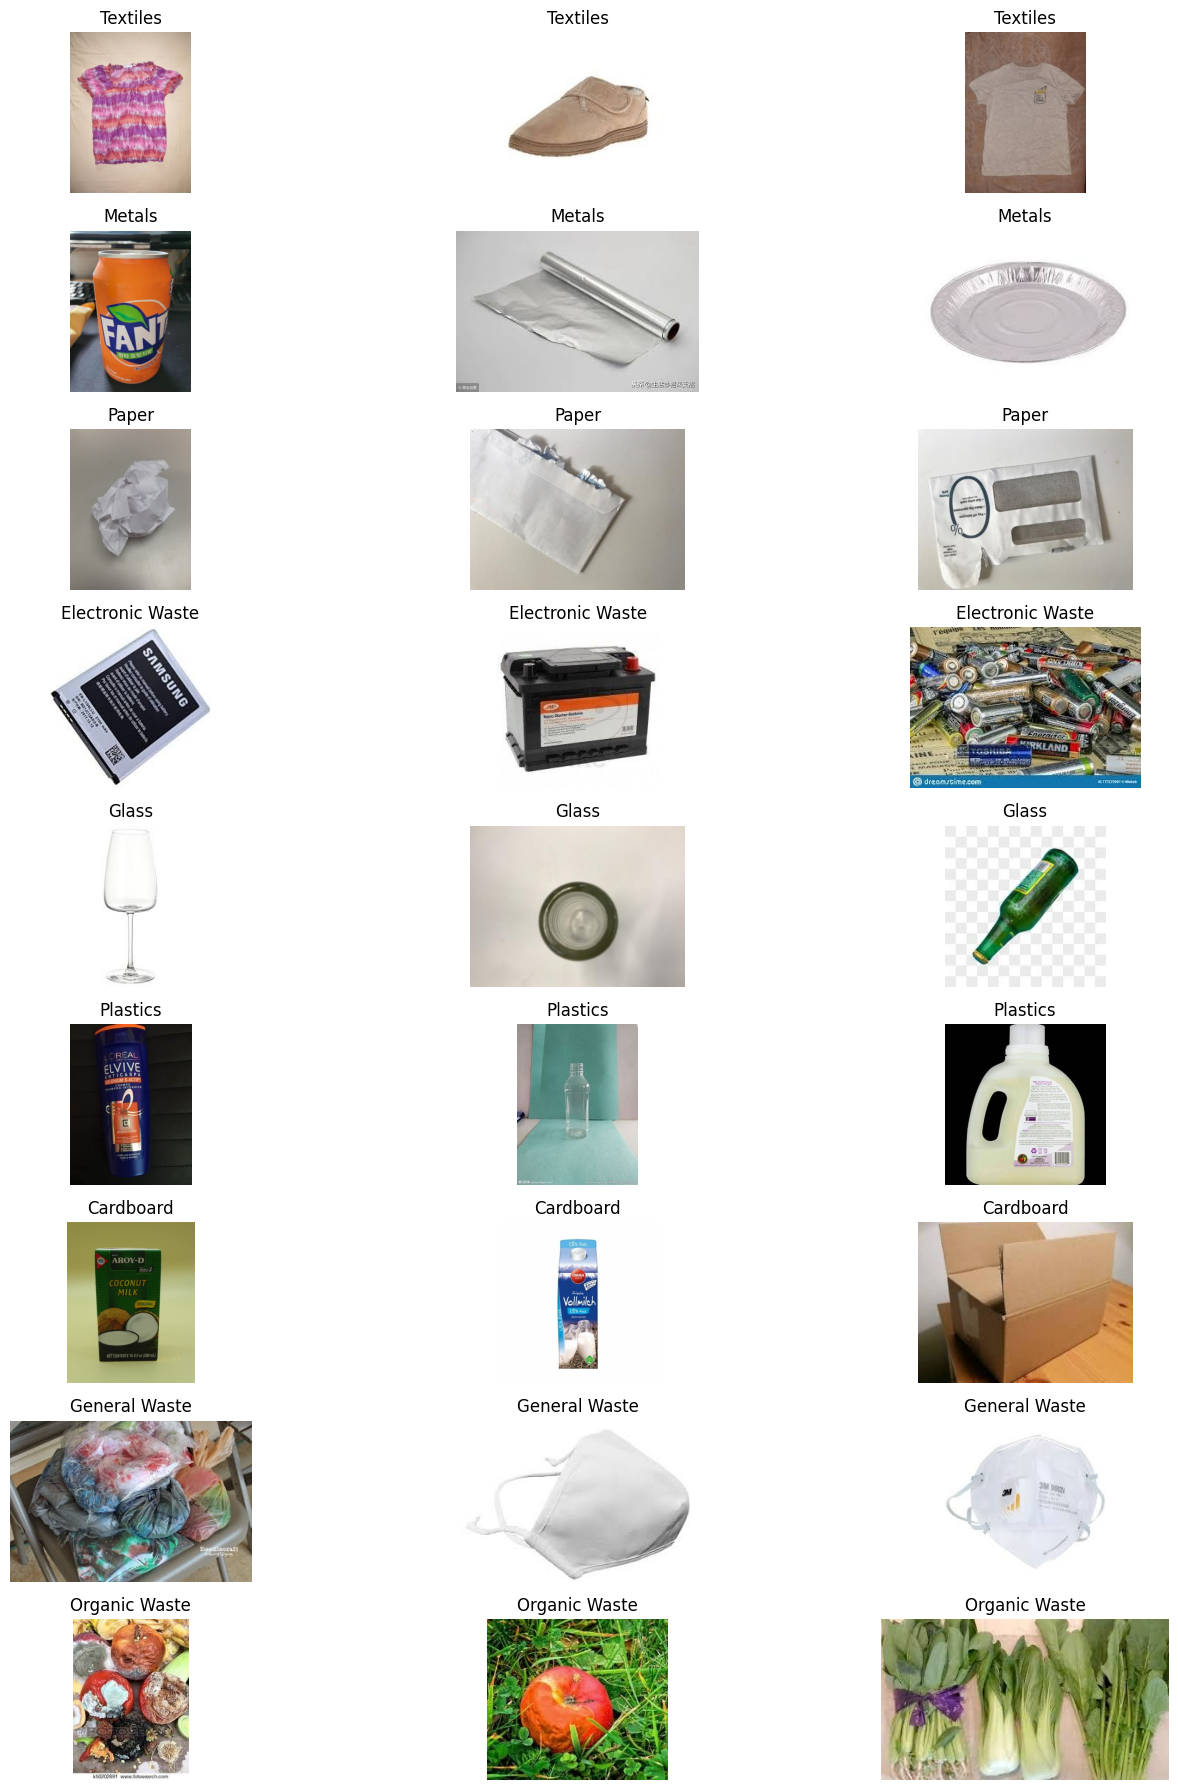

In [ ]:
import matplotlib.pyplot as plt
import os
from PIL import Image

def display_sample_images(base_dir, num_samples=3):
    """Displays a few sample images from each class."""
    garbage_types = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d)) and d != 'waste_dataset']
    num_classes = len(garbage_types)

    plt.figure(figsize=(15, num_classes * 2))

    for i, garbage_type in enumerate(garbage_types):
        folder_path = os.path.join(base_dir, garbage_type)
        image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))]

        # Select random sample images
        sample_images = np.random.choice(image_files, min(num_samples, len(image_files)), replace=False)

        for j, image_file in enumerate(sample_images):
            image_path = os.path.join(folder_path, image_file)
            try:
                img = Image.open(image_path)
                plt.subplot(num_classes, num_samples, i * num_samples + j + 1)
                plt.imshow(img)
                plt.title(garbage_type)
                plt.axis('off')
            except Exception as e:
                print(f"Could not open image {image_path}: {e}")

    plt.tight_layout()
    plt.show()

display_sample_images(extract_path)

**check for the dimensions and the channel**

In [ ]:
import os
from PIL import Image

# Retrieve the names of all folders (representing trash types) within the dataset directory
garbage_types = os.listdir(extract_path)

# Set to store unique image dimensions for the entire dataset
all_dimensions_set = set()

# Iterate over each trash type (folder) to process images
for garbage_type in garbage_types:
    folder_path = os.path.join(extract_path, garbage_type)

    # Verify that the current item is a directory
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))]

        # Display the count of images in the current folder
        num_images = len(image_files)
        print(f"{garbage_type} folder contains {num_images} images.")

        # Loop over each image to check its dimensions
        for image_file in image_files:
            image_path = os.path.join(folder_path, image_file)
            try:
                with Image.open(image_path) as img:
                    # Extract the width, height, and channels (color depth) of the image and add to the dimensions set
                    width, height = img.size
                    channels = len(img.getbands())
                    all_dimensions_set.add((width, height, channels))
            except Exception as e:
                print(f"Could not open image {image_path}: {e}")


# Determine if all images in the entire dataset have the same dimensions
if len(all_dimensions_set) == 1:
    width, height, channel = all_dimensions_set.pop()
    print(f"\nAll images in the dataset have the same dimensions: {width}x{height} with {channel} color channels.")
else:
    print("\nThe images in the dataset have different dimensions or color channels.")
    print("Unique dimensions found:", all_dimensions_set)

Textiles folder contains 9619 images.
Metals folder contains 3431 images.
Paper folder contains 4119 images.
Electronic Waste folder contains 945 images.
Glass folder contains 6528 images.
Plastics folder contains 4754 images.
Cardboard folder contains 2744 images.
General Waste folder contains 2811 images.
Organic Waste folder contains 997 images.

The images in the dataset have different dimensions or color channels.
Unique dimensions found: {(263, 192, 3), (447, 800, 3), (715, 500, 3), (451, 112, 3), (998, 609, 3), (1000, 750, 3), (457, 457, 3), (963, 933, 3), (900, 675, 3), (434, 295, 3), (400, 610, 3), (400, 264, 3), (613, 400, 3), (300, 273, 3), (400, 823, 3), (475, 233, 3), (330, 313, 3), (494, 800, 3), (364, 273, 3), (534, 400, 3), (400, 477, 3), (766, 766, 3), (598, 400, 3), (481, 641, 3), (224, 218, 3), (720, 638, 3), (405, 273, 3), (200, 252, 3), (210, 280, 3), (473, 605, 3), (400, 428, 3), (293, 800, 3), (570, 627, 3), (156, 324, 3), (812, 1024, 3), (768, 1024, 3), (318, 49

**inference**

dataset contains images with:

Varying dimensions (from 95×225 to 3000×4000+).

Inconsistent color channels (some have 1, 3, or even 4 channels — meaning grayscale, RGB, or RGBA).

This inconsistency will break the model during training if not fixed.

 The Fix: Standardize All Images
Here’s what we’ll do:

✅ Resize all images to a fixed dimension (e.g., 224x224).

✅ Convert all images to RGB (3 channels).

✅ Save them into a cleaned dataset folder.

**Image Standardization (Resizing and Format Cleanup)**

In [ ]:
import os
from PIL import Image

# Paths
raw_dataset_path = extract_path  # Original images
cleaned_dataset_path = "/content/cleaned_dataset"  # New folder
os.makedirs(cleaned_dataset_path, exist_ok=True)

# Set fixed dimensions and format
TARGET_SIZE = (224, 224)

for class_name in os.listdir(raw_dataset_path):
    class_path = os.path.join(raw_dataset_path, class_name)
    cleaned_class_path = os.path.join(cleaned_dataset_path, class_name)
    os.makedirs(cleaned_class_path, exist_ok=True)

    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            if image_name.lower().endswith(('jpg', 'jpeg', 'png')):
                input_path = os.path.join(class_path, image_name)
                output_path = os.path.join(cleaned_class_path, image_name)

                try:
                    with Image.open(input_path) as img:
                        # Convert to RGB (3 channels)
                        img = img.convert("RGB")

                        # Resize to fixed size
                        img = img.resize(TARGET_SIZE)

                        # Save cleaned image
                        img.save(output_path)

                except Exception as e:
                    print(f"❌ Failed to process {input_path}: {e}")


# **step 3 : dataset preparation**


### **Step 3.1 | Centralize Dataset Information**

🔍 Concern:
We have all our images scattered across multiple folders, one for each garbage class. We need a unified view of the data for easy manipulation.

🛠️ Strategy:
Create a DataFrame that contains file paths and corresponding labels.

In [ ]:

import os
import pandas as pd

# Define the cleaned dataset path
cleaned_dataset_path = "/content/cleaned_dataset"

# Folders to exclude (non-garbage class folders)
EXCLUDED_FOLDERS = {
    'annotations.json',
    'dataset2_annotation.json',
    'dataset3_annotation.json',
    'dataset4_annotation.json',
    'dataset5_annotation.json',
    'waste_dataset'
}

def build_dataframe(base_dir):
    data = []
    for folder_name in os.listdir(base_dir):
        if folder_name in EXCLUDED_FOLDERS:
            continue

        folder_path = os.path.join(base_dir, folder_name)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                if file.lower().endswith(('jpg', 'jpeg', 'png')):
                    data.append((os.path.join(folder_path, file), folder_name))

    return pd.DataFrame(data, columns=["filepath", "label"])

# Build the DataFrame
df = build_dataframe(cleaned_dataset_path)

# Display sample rows
print(df.head())
print(f"\nTotal images found: {len(df)}")
print(f"Classes found: {df['label'].nunique()}")
print(f"Class distribution:\n{df['label'].value_counts()}")


                                            filepath     label
0  /content/cleaned_dataset/Textiles/Textiles_133...  Textiles
1  /content/cleaned_dataset/Textiles/Textiles_549...  Textiles
2  /content/cleaned_dataset/Textiles/Textiles_585...  Textiles
3  /content/cleaned_dataset/Textiles/Textiles_628...  Textiles
4  /content/cleaned_dataset/Textiles/Textiles_417...  Textiles

Total images found: 35948
Classes found: 9
Class distribution:
label
Textiles            9619
Glass               6528
Plastics            4754
Paper               4119
Metals              3431
General Waste       2811
Cardboard           2744
Organic Waste        997
Electronic Waste     945
Name: count, dtype: int64


### **Step 3.2 | Stratified Data Splitting: Train & Validation**

In [ ]:
from sklearn.model_selection import train_test_split

# Perform stratified split (preserving class distribution)
train_df, val_df = train_test_split(
    df,
    test_size=0.2,  # 20% for validation
    stratify=df["label"],
    random_state=42
)

# Show sizes
print(f"Training set size: {len(train_df)} images")
print(f"Validation set size: {len(val_df)} images")

# Optional: Check class distribution in each set
print("\nClass distribution in training set:")
print(train_df["label"].value_counts())

print("\nClass distribution in validation set:")
print(val_df["label"].value_counts())


Training set size: 28758 images
Validation set size: 7190 images

Class distribution in training set:
label
Textiles            7695
Glass               5222
Plastics            3803
Paper               3295
Metals              2745
General Waste       2249
Cardboard           2195
Organic Waste        798
Electronic Waste     756
Name: count, dtype: int64

Class distribution in validation set:
label
Textiles            1924
Glass               1306
Plastics             951
Paper                824
Metals               686
General Waste        562
Cardboard            549
Organic Waste        199
Electronic Waste     189
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

# Perform stratified split (preserving class distribution)
train_df, val_df = train_test_split(
    df,
    test_size=0.2,  # 20% for validation
    stratify=df["label"],
    random_state=42
)

# Show sizes
print(f"Training set size: {len(train_df)} images")
print(f"Validation set size: {len(val_df)} images")

# Show class distribution as percentages
print("\nClass distribution in training set (%):")
print((train_df["label"].value_counts(normalize=True) * 100).round(2))

print("\nClass distribution in validation set (%):")
print((val_df["label"].value_counts(normalize=True) * 100).round(2))


Training set size: 28758 images
Validation set size: 7190 images

Class distribution in training set (%):
label
Textiles            26.76
Glass               18.16
Plastics            13.22
Paper               11.46
Metals               9.55
General Waste        7.82
Cardboard            7.63
Organic Waste        2.77
Electronic Waste     2.63
Name: proportion, dtype: float64

Class distribution in validation set (%):
label
Textiles            26.76
Glass               18.16
Plastics            13.23
Paper               11.46
Metals               9.54
General Waste        7.82
Cardboard            7.64
Organic Waste        2.77
Electronic Waste     2.63
Name: proportion, dtype: float64


**✅ Stratified Split Inferences**

📊 Dataset Overview:

Training Set: 28758 images

Validation Set: 7190 images

The class distributions in both the training and validation sets closely mirror the overall distribution in the entire dataset, indicating that stratification during the split was successful.

### **step 3.3 : data augmentation and rescaling**

**✅ 1. 📁 Make a Working Copy of Your Cleaned Dataset**

In [ ]:
import shutil

# Define source and destination
src_folder = "/content/cleaned_dataset"
augmented_folder = "/content/augmented_dataset"

# Create a deep copy of the dataset
shutil.copytree(src_folder, augmented_folder, dirs_exist_ok=True)
print("Working copy created at:", augmented_folder)



Working copy created at: /content/augmented_dataset


🔍 Concern:
We have limited images, so we risk overfitting.
Neural networks work better with input values between 0 and 1, but our images have pixel values between 0 and 255.

🛠️ Strategy:
Augment the training images to artificially increase dataset size.
Rescale both training and validation images for better network performance.

**Note on Data Augmentation in Validation Set**

Data augmentation is a technique primarily used to expand the training dataset in order to improve the model's capacity to generalize and avoid overfitting. The primary objective is to introduce variability and mimic potential real-world distortions in the training images without actually collecting more data.

On the other hand, the validation set's role is to provide an *unbiased* evaluation of a model's performance on unseen data. Thus, we want the validation data to remain consistent throughout the model's training process to ensure that our evaluations are stable and reproducible. Applying augmentations to the validation set would introduce random variability in the evaluation metrics across different epochs, making it harder to determine whether changes in the model's performance are due to the model's learning or just the variability introduced by augmentations.

Therefore, to maintain a consistent and clear evaluation benchmark, I refrain from applying data augmentation to the validation set, using only rescaling to ensure the pixel values are in a similar range as the augmented training images.

📌 Designing Data Augmentation for Trash Classification



**Suitable Transformations:**

**Rescaling**: Necessary to normalize pixel values between 0 and 1.

**Rotation**: Captures objects in various orientations.

**Width and Height Shift**: Models minor positional changes.

**Zoom**: Simulates different object distances.

**Flip**: Captures different horizontal or vertical orientations.

**Shear**: Provides a skewed perspective of images.

**Brightness Adjustment**: Adapts images to diverse lighting conditions.

**Channel Shift**: Alters colors for added variety.

**Fill Mode**: Addresses missing pixel values.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Augmentations for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.05,
    brightness_range=[0.9, 1.1],
    channel_shift_range=10,
    fill_mode='nearest'
)

# Validation set should remain untouched, only rescale
val_datagen = ImageDataGenerator(rescale=1./255)


**Step 3.4 | Generating Batches of Images**

🔍 Concern:
We can't load all images at once due to memory constraints.
We want to benefit from the DataFrame format to feed our images into our model.
Most CNN architectures often perform better with square images.
We aim to avoid manual one-hot encoding of labels.
Ensuring consistent ordering and reproducibility during training.

🛠️ Strategy:
Use the flow_from_dataframe method to generate batches of images and labels directly from our DataFrame

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 28758 validated image filenames belonging to 9 classes.
Found 7190 validated image filenames belonging to 9 classes.


**Visualize Augmented Samples**

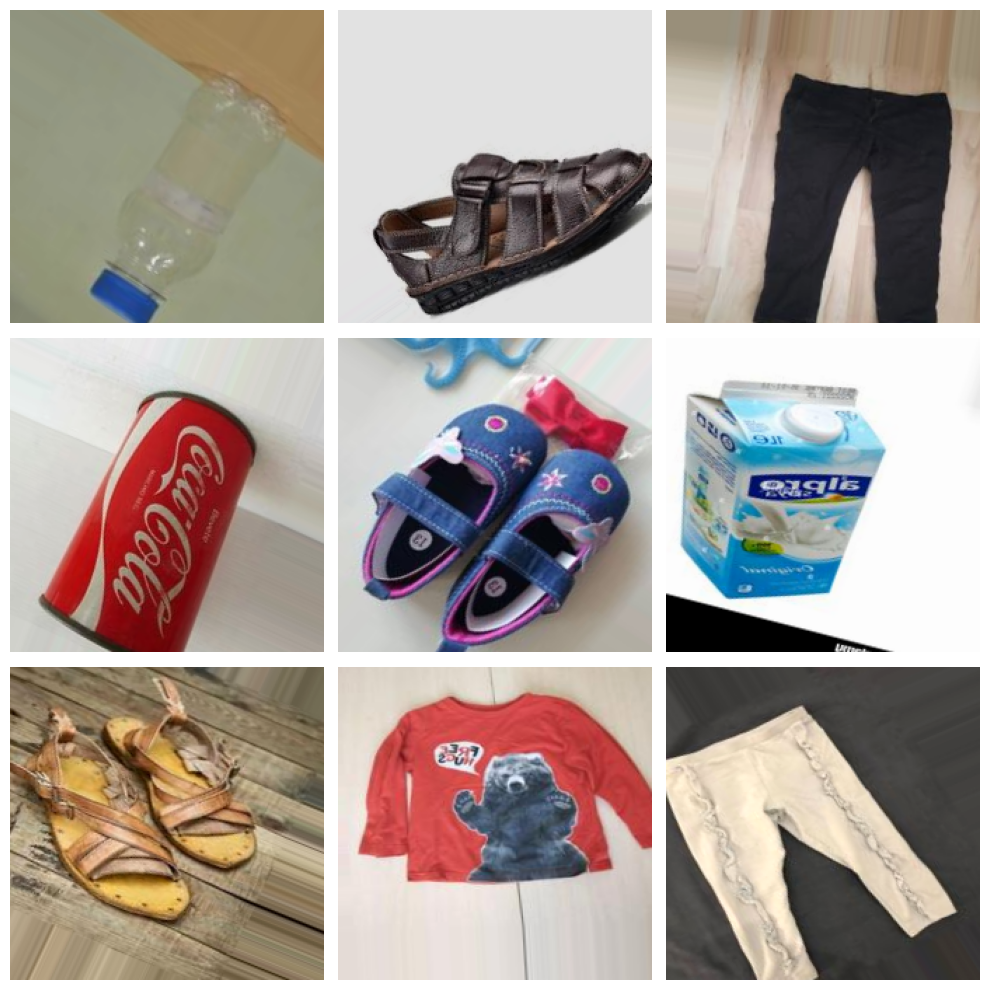

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Display 9 augmented images from one batch
sample_images, sample_labels = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


 **number of batches**

In [ ]:
# Calculate the number of batches
num_train_batches = len(train_generator)
num_val_batches = len(val_generator)

print(f"Number of batches in train_generator: {num_train_batches}")
print(f"Number of batches in val_generator: {num_val_batches}")

Number of batches in train_generator: 899
Number of batches in val_generator: 225


**📌 Understanding ImageDataGenerator**

When we create *train_generator* using *flow_from_dataframe*, we're not pre-generating all batches of images with their transformations. What we are doing is setting up a framework or a "pipeline" that knows how to fetch and transform the images when requested.

The benefit of ImageDataGenerator is precisely this: it generates augmented images on-the-fly during each step of each epoch. It doesn't pre-generate and store them.

# **Step 4 | Addressing Dataset Imbalances**

**NB** : first we will work on non_augmented dataset just rescaling

In [ ]:
dataset_path = "/content/cleaned_dataset"
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Define generators (only rescale)
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Use your previously split DataFrames: train_df, val_df
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 28758 validated image filenames belonging to 9 classes.
Found 7190 validated image filenames belonging to 9 classes.


🛠️ **Addressing Imbalance Using Class Weights:**

To tackle our imbalanced image dataset, we'll utilize class weights. These weights assign more importance to underrepresented classes during training. The weights are computed inversely proportional to class frequencies using utilities like compute_class_weight from scikit-learn based on the distribution of images in each class. The formula is:


$$
\text{weight}(c) = \frac{\text{total number of samples}}{\text{number of classes} \times \text{number of samples in class } c}
$$

These computed weights are then passed to the model.

* basically we are using The class_weight='balanced' option in sklearn.utils.class_weight.compute_class_weight automatically increases the weight for underrepresented classes and decreases it for overrepresented classes to address class imbalance during training.



In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get class indices from the generator
class_indices = train_generator.class_indices  # e.g., {'Cardboard': 0, 'Electronic Waste': 1, ...}

# Invert the dict: {0: 'Cardboard', 1: 'Electronic Waste', ...}
index_to_label = {v: k for k, v in class_indices.items()}

# Get class labels from training dataframe
labels = train_df['label']

# Compute class weights using sklearn (returns label -> weight)
class_weights_raw = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
label_to_weight = dict(zip(np.unique(labels), class_weights_raw))

# Build final class_weights dict using class indices
class_weights_dict = {
    class_indices[label]: label_to_weight[label]
    for label in label_to_weight
}

# ✅ Now this dict is ready to be used in model.fit()
print("✅ Final class_weights_dict (index → weight):\n")
for idx, weight in class_weights_dict.items():
    print(f"Class {idx:2d} ({index_to_label[idx]:17s}): {weight:.2f}")


✅ Final class_weights_dict (index → weight):

Class  0 (Cardboard        ): 1.46
Class  1 (Electronic Waste ): 4.23
Class  2 (General Waste    ): 1.42
Class  3 (Glass            ): 0.61
Class  4 (Metals           ): 1.16
Class  5 (Organic Waste    ): 4.00
Class  6 (Paper            ): 0.97
Class  7 (Plastics         ): 0.84
Class  8 (Textiles         ): 0.42


**NB** for modeling you need to pass class_weight_dict